# Introduction to Geometric Shapes

This jupyter notebook is a companion to [this](https://medium.com/@neilbardhan/location-location-location-46bba15d9b21?sk=44d4752f88733111f70c069456611fdc) post on Medium, which serves as an introduction to the basic building blocks of geospatial data. I strongly recommend going through these works in tandem as the material covered in both will help inform your knowledge of geospatial data.

For this notebook, I will be using 
  * [shapely](https://shapely.readthedocs.io/en/latest/) for creating the geometric objects. It can be installed by running the command `pip install shapely` in your system terminal. 
  * [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) to create interactive maps to display the geometric objects on a basemap to help us get a more intuitive understanding of these objects and their geometries. This can be installed by running the command `pip install ipyleaflet`.

## Importing the libraries

In [1]:
import os
import json
import random
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import JSON
from shapely.ops import polygonize
from ipyleaflet import Map, GeoJSON, Marker, Polyline
from shapely.geometry import (Point, LineString, Polygon, LinearRing, MultiPolygon)

In [2]:
os.chdir('..')

## Points

A point is the representation of a real-world location using it's Latitude and Longitude coordinates. `Shapely` has a function called `Point` that takes as input the longitude and the latitude of a Position and returns a `POINT` object which is a tuple containing those coordinates.

In [3]:
lat = 51.520
long = -0.093
barbican = Point([long, lat])
somewhere = Point([lat, long]) ## inherently incorrect, but serves as an illustration
print(barbican)
print(somewhere)

POINT (-0.093 51.52)
POINT (51.52 -0.093)


This brings up an important question, *Why is the input* `[long, lat]` *in contrast to the conventional `[lat, long]`?* That's because `Shapely`'s `Point` function resolves the earth's geometric coordinates (long/lat) to the Cartesian coordinate system, where longitude is analogous to values on the $X$ axis and latitude is analogous to values on the $Y$ axis. Therefore, a `[long, lat]` pair can be considered to be similar to a `[x, y]` pair. If we were to reverse this, we would end up in an incorrect position on the earth's surface. Let's map it out!

### Plotting Points

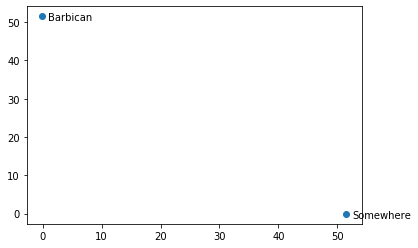

In [4]:
x = [barbican.x, somewhere.x]
y = [barbican.y, somewhere.y]
names = ['Barbican', 'Somewhere']

map_fig = plt.scatter(x, y)

for i, txt in enumerate(names):
    map_fig._axes.annotate(txt, (x[i] + 1, y[i] - 1))

While we can use `matplotlib` for plotting our points, such plots provide no contextual information from a geographic perspective. We already know where these points lie in the coordinate space, what we would like to know is where they lie on the earth's surface.
To achieve this, we almost always need the help of **basemaps**, previously designed layers containing the visual geospatial information that we are used to seeing on Google Maps or OpenStreetMaps. We can build our own basemaps, however `ipyleaflet`, running on **[leaflet.js](https://leafletjs.com/examples/quick-start/)**, serves as a great ready to go tool for our mapping needs.

In [5]:
m = Map(zoom=2)
marker_barbican = Marker(location=[barbican.y, barbican.x], draggable=False)
marker_somewhere = Marker(location=[somewhere.y, somewhere.x], draggable=False)
m.add_layer(marker_barbican)
m.add_layer(marker_somewhere)
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Now this is information we can relate to! The 2 points here are - the correct point and the incorrect point. Can you guess which is the incorrect one?
Accidentally interchanging the lat and the long provide us with a point off the eastern coast of Africa as opposed to a cultural center in the City of London. Here is what the correct map should look like with only the correct point plotted.

In [6]:
m = Map(center=[barbican.y, barbican.x], zoom = 20)
marker_barbican = Marker(location=[barbican.y, barbican.x], draggable=False)
m.add_layer(marker_barbican)
m

Map(center=[51.52, -0.093], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Lines

A Line in it's simplest form connects two Points with a straight line. `Shapely` provides us with the `LineString` function to create `Line` geometric objects which takes as input at least two points. We have already considered The Barbican Center `[-0.093, 51.520]`, let's consider the Royal Observatory at Greenwich `[0.0, 51.476]`. A Line would simply connect these 2 Points.

In [7]:
royal_observatory = Point([0.0, 51.476])

l1 = LineString([barbican, royal_observatory])
print(l1)

LINESTRING (-0.093 51.52, 0 51.476)


### Plotting Lines

Let's plot this line in `matplotlib` and overlay it on a basemap using `mplleaflet`. This is a non-directional, straight line connecting 2 points, The Barbican and The Royal Observatory in London.

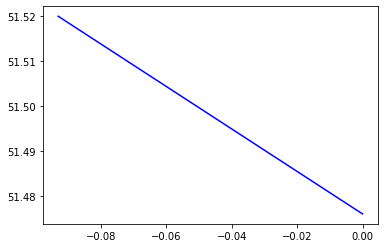

In [8]:
x = [barbican.x, royal_observatory.x]
y = [barbican.y, royal_observatory.y]

line_fig = plt.plot(x, y, color = 'blue')[0]

In [9]:
m = Map(center = [barbican.y, barbican.x], zoom =10)
line = Polyline(
    locations = [
        [barbican.y, barbican.x],
        [royal_observatory.y, royal_observatory.x]
    ],
    color = '#01796F',
    fill = False
)
m.add_layer(line)
m

Map(center=[51.52, -0.093], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Polygons

To help us better understand Polygons, we need to understand the concept of **Linear Rings**. A linear ring is a closed LineString with **four or more** Positions, where the first and last Positions are the same. A linear ring is the boundary of a surface or the boundary of a hole in a surface.

Polygons are arrays of Linear Ring coordinates. To illustrate Polygons and Linear Rings, in addition to The Barbican `[-0.093, 51.520]` and the Royal Observatory `[0.0, 51.476]`, consider the Olympic Stadium `[-0.0165, 51.538]`. Let's assume that on our London day trip that we make a stop at the Olympic Stadium *before* heading to the Royal Observatory.

In [10]:
## Create Point object for the Olympic Stadium
stadium = Point([-0.0165, 51.538])

In [11]:
## We have 3 points/Positions/Vertices for our Polygon
print(barbican)
print(royal_observatory)
print(stadium)

POINT (-0.093 51.52)
POINT (0 51.476)
POINT (-0.0165 51.538)


We feed in our Point coordinates to the `Polygon` function from `shapely` to get a `Polygon` object. Note that `shapely` is able to intuit that the first and last positions must be equal. Therefore, we needn't provide the last Point as an input.

It is important to remember, that we must traverse our Points in clockwork order to get the correct Polygon.

In [12]:
point_list = [barbican, stadium, royal_observatory]
poly = Polygon([[p.x, p.y] for p in point_list])
print(poly)

POLYGON ((-0.093 51.52, -0.0165 51.538, 0 51.476, -0.093 51.52))


### Plotting Polygons

We have created our Polygon, given the Points. Now let's plot our Polygon in `matplotlib` and `ipyleaflet`.

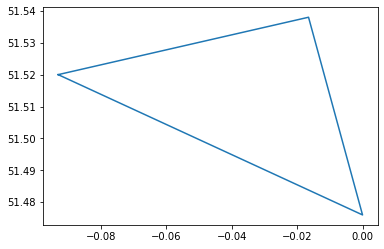

In [13]:
coords = poly.exterior.coords
pts = list(coords)
x,y = zip(*pts)
poly_fig = plt.plot(x,y)[0]

In [14]:
polygon = ipyleaflet.Polygon(
    locations=[[p.y, p.x] for p in point_list],
    color="#01796F",
    fill_color="#01796F"
)
m = Map(center=(poly.centroid.y, poly.centroid.x), zoom=12)
m.add_layer(polygon);
m

Map(center=[51.511333333333326, -0.0365], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

### Holes in Polygons

Polygons are not just closed areas, but can have internal linear rings or holes nested in exterior linear rings. The image below shows what that would look like on a map.

![polygon_holes](inner_ring.png)

Now would be a good time to introduce **geoJSON** files. So far, we have been working with hardcoded values. We live in the age of Big Data and rarely come across values in the tens and hundreds. geoJSON files are a lightweight, JSON standard file-format used to store geometric data.
Working with geoJSON files in Python is very easy. We will be using the [`geopandas`](https://geopandas.org/) library to work with geoJSON files, `geopandas` is an extension of the `pandas` library and makes working with geoJSON a breeze.

## geoJSON and geopandas

### Importing the libraries

We will be using `geopandas` for reading in `.geojson` files. We will also be using a web-tool from [geojson.io](https://geojson.io) called `geojsonio` to display our geometric object in the browser. 

In [15]:
import geojsonio
import geopandas as gpd

### Importing the dataset

In [16]:
DATA_PATH = os.getcwd() + "//data//"
fname = "inner_ring.geojson"

In [17]:
poly_ring = gpd.read_file(DATA_PATH + fname)
poly_ring.head()

,geometry
0,"POLYGON ((12.00000 60.00000, -12.00000 60.0000..."


In [18]:
print(type(poly_ring))

<class 'geopandas.geodataframe.GeoDataFrame'>


`geopandas` reads in geospatial data from a multitude of formats and returns `geopandas` DataFrames. This abstraction of the geospatial data helps us perform a large variety of operations on our data by leveraging the convenience and efficiency of data frames.

### Visualizing the data

We can visualize geoJSON geometries in 2 ways -
   1. Using `geojsonio` - This is the most convenient way as we simply pass our geometry to a 3rd party application to do all the plotting.
   2. Using `geopandas` and `mplleaflet` - We use our tried and tested method of first plotting out our geometry in `matplotlib` and then overlaying the figure on a basemap.

#### Using `geojsonio`

In [19]:
poly_ring_json = poly_ring.to_json()
geojsonio.display(poly_ring_json)

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22id%22%3A%20%220%22%2C%20%22type%22%3A%20%22Feature%22%2C%20%22properties%22%3A%20%7B%7D%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B12.0%2C%2060.0%5D%2C%20%5B-12.0%2C%2060.0%5D%2C%20%5B-12.0%2C%2040.0%5D%2C%20%5B12.0%2C%2040.0%5D%2C%20%5B12.0%2C%2060.0%5D%5D%2C%20%5B%5B-5.0%2C%2052.0%5D%2C%20%5B5.0%2C%2052.0%5D%2C%20%5B5.0%2C%2048.0%5D%2C%20%5B-5.0%2C%2048.0%5D%2C%20%5B-5.0%2C%2052.0%5D%5D%5D%7D%7D%5D%7D'

Running the above cell will open a new tab in your browser with the geoJSON data being displayed on a map in the left hand side panel and the raw data in the right hand side panel. [geojson.io](https://www.geojson.io) is a powerful web tool, you can add additional layers, edit the geoJSON file to add more geometries, save and share your work.

#### Using `geopandas` and `ipyleaflet`

`geopandas` has a very handy `plot` function that plots the geometry of our `geopandas` DataFrame. The `plot` function returns a `matplotlib` object that we can overlay on top of our `ipyleaflet` basemap.

In [25]:
# Create basemap, add layer
m = Map(center=[barbican.y, barbican.x], zoom=4)
poly_ring_layer = ipyleaflet.GeoData(geo_dataframe=poly_ring,
                       style={'color': '#01796F',
                              'weight': 0.3, 
                              'fillColor':'#01796F', 
                              'fillColorOpacity':0.75
                             })
m.add_layer(poly_ring_layer)
# m.add_control(LayersControl())
m

Map(center=[51.52, -0.093], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Multi Geometries

All the geometries we have seen have been single geometries; `Points`, `Lines` and `Polygons`. Because of the complexities of real-world shapes and figures, there are certain limitations of using single shapes as often the physical world contains entities that aren't just a single contiguous shape. For example, countries like the United Kingdom and the United States have multiple disconnected parts that need multiple shapes to correctly represent one geopolitical entity.

GeoJSON has versions of each of the three basic types with Multi stuck on the front: `MultiPolygon`, `MultiLineString`, `MultiPoint`. Together they give us something of a solution for multiple shapes.
The way Multi Features are created is the same across all the types: **everything moves down a step of nesting**. The coordinates of the Barbican are represented as `[-0.093, 51.52]`, so a `MultiPoint` of the Barbican, the Olympic Stadium and the Royal Observatory will look like `[[-0.093, 51.520], [-0.0165, 51.538], [0.0, 51.476]]`.

### Multi Points

In [26]:
## Reading in a file containing multiple points
file_name = 'multi_points.geojson'
multi_points = gpd.read_file(DATA_PATH + file_name)
multi_points.head()

,geometry
0,"MULTIPOINT (-0.09300 51.52000, 0.00000 51.4760..."


A `MultiPoint` geometry contains multiple points in a single geometry and can be visualized on a basemap as shown below.

In [28]:
# Create basemap, add layer
m = Map(center=[barbican.y, barbican.x], zoom=10)
multi_point_layer = ipyleaflet.GeoData(geo_dataframe=multi_points,
                       style={'color': '#01796F',
                              'weight': 0.3, 
                             })
m.add_layer(multi_point_layer)
# m.add_control(LayersControl())
m

Map(center=[51.52, -0.093], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

### Multi Lines

In [30]:
## Reading in a file containing multiple lines
file_name = 'multi_line.geojson'
multi_lines = gpd.read_file(DATA_PATH + file_name)
multi_lines.head()

,geometry
0,"MULTILINESTRING ((-0.09300 51.52000, 0.00000 5..."


The logic of Multiple Geometries extends to MultiLines and MultiPolygons as well. Here, we have a single geometry containing 2 different `LineStrings` as visualized below.

In [35]:
# Create basemap, add layer
m = Map(center=[barbican.y, barbican.x], zoom=12)
multi_line_layer = ipyleaflet.GeoData(geo_dataframe=multi_lines,
                       style={'color': '#01796F',
                              'weight': 2, 
                             })
m.add_layer(multi_line_layer)
# m.add_control(LayersControl())
m

Map(center=[51.52, -0.093], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

### Multi Polygons

In [36]:
file_name = 'hawaii.geojson'
multi_poly = gpd.read_file(DATA_PATH + file_name)
multi_poly.head()

,name,abbreviation,capital,city,population,area,waterarea,landarea,houseseats,statehood,group,geometry
0,Hawaii,HI,Honolulu,Honolulu,1404054,28314,11678,16635,2,1959-08-20,US States,"MULTIPOLYGON (((-155.77823 20.24574, -155.7727..."


A `MultiPolygon` geometry contains multiple polygon geometries within it to accurately reflect different shapes that comprise one geopolitical entity. For example, the US state of Hawaii contains multiple islands, each is it's own polygon, but is part of a `MultiPolygon` geometry.

In [41]:
map_center = multi_poly['geometry'][0].centroid

In [42]:
# geom = data['geometry']['coordinates']
# data['geometry']['type']
# # MultiPolygon()
# ls = []
# centroids = []
# for elem in geom:
#     temp = Polygon(elem[0])
#     ls.append(temp)
#     centroids.append(temp.centroid)
# #     break
# #     temp = Polygon(elem)
# #     ls.append(temp)
# mlp = MultiPolygon(ls)
# print(mlp.centroid)
# map_center = [mlp.centroid.y, mlp.centroid.x]
# print(ls)
# print(centroids)

In [45]:
# m = Map(center=map_center, zoom=6)

# geo_json = GeoJSON(
#     data=data,
#     style={
#         'color': 'black', 'opacity': 1, 'dashArray': '0', 'fillOpacity': 0.7, 'weight': 1, 'fillColor': '#01796F'
#     }
# #     hover_style={
# #         'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
# #     },
# #     style_callback=random_color
# )
# m.add_layer(geo_json)
# marker = Marker(location=map_center, draggable=False)
# m.add_layer(marker)
# # for x in centroids:
# #     print([x.y, x.x])
# #     m.add_layer(Marker(location=[x.y, x.x], draggable=False))
# m

m = Map(center=[map_center.y, map_center.x], zoom=6)
multi_poly_layer = ipyleaflet.GeoData(geo_dataframe=multi_poly,
                                      style={
                                          'color': 'black',
                                          'opacity': 1,
                                          'fillOpacity': 0.7,
                                          'weight': 1,
                                          'fillColor': '#01796F'
                                      })
m.add_layer(multi_poly_layer)
m

Map(center=[20.250596010816963, -156.35004069378328], controls=(ZoomControl(options=['position', 'zoom_in_text…

## FeatureCollection

A Feature is the combination of the geometries and properties of a single entity in one JSON object. A FeatureCollection expands upon this by aggregating multiple features into one JSON object.

In [46]:
## Reading in a file containing multiple polygons
file_name = 'Emergency_Services.geojson'
fc = gpd.read_file(DATA_PATH + file_name)
fc.head()

,OBJECTID,NAME,PHONE,ADDRESS_1,EASTING,NORTHING,geometry
0,4,The British Home,020 8670 8261,Crown Lane,531665.583780,171071.707000,POINT (-0.10769 51.42337)
1,3,St Thomas' Hospital,020 7188 7188,Westminster Bridge Road,530690.266411,179520.014880,POINT (-0.11859 51.49952)
2,1,King's College Hospital,,Denmark Hill,532480.501884,176018.086789,POINT (-0.09413 51.46763)
3,2,Lambeth Hospital,,108 Landor Road,530476.116328,175768.648988,POINT (-0.12306 51.46586)


A FeatureCollection is simply an array of Features. A FeatureCollection also must have Feature objects under the key `features`. The array needs to contain Feature objects only. When parsed by `geopandas` into a DataFrame, a FeatureCollection will yield multiple rows in the data frame, one for each feature. The dataframe above is a dataset containing the geometries of 4 hospitals in the London Borough of Lambeth. The source geoJSON looks as follows - 

In [47]:
print(fc.to_json(indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "id": "0",
      "type": "Feature",
      "properties": {
        "ADDRESS_1": "Crown Lane",
        "EASTING": 531665.58378,
        "NAME": "The British Home",
        "NORTHING": 171071.707,
        "OBJECTID": 4,
        "PHONE": "020 8670 8261"
      },
      "geometry": {
        "type": "Point",
        "coordinates": [
          -0.107692276012846,
          51.423370584443816
        ]
      }
    },
    {
      "id": "1",
      "type": "Feature",
      "properties": {
        "ADDRESS_1": "Westminster Bridge Road",
        "EASTING": 530690.266411,
        "NAME": "St Thomas' Hospital",
        "NORTHING": 179520.01488,
        "OBJECTID": 3,
        "PHONE": "020 7188 7188"
      },
      "geometry": {
        "type": "Point",
        "coordinates": [
          -0.11859200065567,
          51.4995183419949
        ]
      }
    },
    {
      "id": "2",
      "type": "Feature",
      "properties": {
        "ADDRES

In [48]:
m = Map(center=[royal_observatory.y, royal_observatory.x], zoom=10)
fc_layer = ipyleaflet.GeoData(geo_dataframe=fc,
                                      style={
                                          'color': 'black'
                                      })
m.add_layer(fc_layer)
m

Map(center=[51.476, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

## Wrapping Up

I hope this was a thorough introduction to the charms of working with geospatial data. If you have any questions, feel free to ask them in the comments of the [companion Medium post](https://medium.com/@neilbardhan/location-location-location-46bba15d9b21?sk=44d4752f88733111f70c069456611fdc). I hope this was an informative read. I will be back soon with Part II, where I will explore some operations involving geospatial data, such as distance calculation and geocoding, in the meantime, feel free to fork this notebook and run your own experiments!